# Deep Q-Network for CartPole

## Q-Estimator & Policy

In [141]:
import torch
from torch import nn, optim, Tensor
from torch.nn import functional as F
import gymnasium as gym
import matplotlib.pyplot as plt
from random import randint, sample
from functools import reduce, partial
from operator import add

DQN is a value-based method learning $Q^*$ with a deep network $Q_\theta$.

We'll implement the Q estimator as an MLP. Consider `CartPole-v1`'s observation & action space:
$$\mathcal{S}\subset \mathbb{R}^4,~ \mathcal{A} = \{ 0, 1 \}$$

As it has a discrete action space, we'll let the estimator take $s$ and produce both $Q_\theta(s, a)~(a=0,1)$ as output.

In [142]:
class Qnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fcs = nn.Sequential(
            nn.Linear(4, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
        )
    
    def forward(self, state):
        return self.fcs(state)

net = Qnet()
opt = optim.Adam(net.parameters(), lr=0.002)
env = gym.make('CartPole-v1', render_mode=None)

Value-based methods use dererministic policy $\pi(a|s) = 1 - \varepsilon \iff a = \argmax\limits_{a} ~Q_\theta(s,a)$. However, we adopt the $\varepsilon$-greedy method, letting the policy explore at a possibility of $\varepsilon$:

In [243]:
def policy(q: Tensor, eps) -> int:
    explore = torch.bernoulli(torch.tensor(eps)).item()
    action = torch.argmax(q).item()
    if explore == 1:
        return randint(0, 1)
    else:
        return action # type: ignore

## Define Training Procedure

Q-Learning adopts TD-error. In fact(this is not a proof), with the *Bellman's Optimal Equation* we have:

$$
Q^{*}(s,a)=r+\gamma \mathbb{E}_{s' \sim P(\cdot|s,a)} \left[ \max_{a'} Q^{*}(s', a') \vert s,a \right]
$$

by approximately using $Q_\theta$ for predicting the next timestep, we can construct TD-loss as

$$
\begin{align*}
\mathcal{L}(\theta) &=\frac{1}{2} \lvert\rvert Q^{*}(s,a) - Q_{\theta}(s,a) \rvert\rvert _{2}^{2} \\
&=\frac{1}{2} \lvert\rvert r + \gamma \,\mathop{\text{max}}\limits_{a'}\,[\text{nograd}(Q_{\theta}(s',a'))]- Q_{\theta}(s,a) \rvert\rvert _{2}^{2}
\end{align*}
$$

During training, we run policy on the environment and collect experiences:

In [494]:
type Experience = tuple[Tensor, int, float, Tensor] # s, a, r, s'

def trajectory(net, env, eps) -> list[Experience]:
    obs, _ = env.reset()
    exps: list[Experience] = []

    scale = torch.tensor([4.8, 1, 0.418, 1])
    while True:
        q = net(torch.from_numpy(obs) / scale)
        action = policy(q, eps)
        obsn, reward, term, trunc, _ = env.step(action)
        exps.append((torch.as_tensor(obs), action, reward, torch.as_tensor(obsn)))
        obs = obsn
        if term or trunc: break
    return exps

gamma = 0.99
def exp_loss(net, exp: Experience, *, tnet = net) -> Tensor:
    s, a, r, sn = exp
    qh = net(s)[a]
    with torch.no_grad():
        q = r + gamma * net(sn).max()
    return F.mse_loss(qh, q) + 2.0 * F.mse_loss(qh, torch.tensor(0.))


[exp_loss(net, e) for e in trajectory(net, env, 0.01)]

[tensor(1.8903, grad_fn=<AddBackward0>),
 tensor(1.8862, grad_fn=<AddBackward0>),
 tensor(1.8808, grad_fn=<AddBackward0>),
 tensor(1.8777, grad_fn=<AddBackward0>),
 tensor(1.8729, grad_fn=<AddBackward0>),
 tensor(1.8763, grad_fn=<AddBackward0>),
 tensor(1.8955, grad_fn=<AddBackward0>),
 tensor(1.9037, grad_fn=<AddBackward0>),
 tensor(1.9165, grad_fn=<AddBackward0>),
 tensor(1.9826, grad_fn=<AddBackward0>)]

## Run Training

In [124]:
''' A result visulizer, by the way '''
def visualize(metrics):
    plt.subplot(211)
    plt.plot([m['reward'] for m in metrics])
    plt.ylabel('reward')
    plt.subplot(212)
    plt.plot([m['qloss'] for m in metrics], 'r')
    plt.xlabel('epoch')
    plt.ylabel('qloss')

The `plain_train` just collets the average batch-loss and perform backprop for each batch for now.

In [456]:
def plain_train(net, env, opt, *, epochs=200, batches=10):
    metrics = []
    for _ in range(epochs):
        tot_reward = 0.
        tot_loss = torch.tensor(0.)
        for _ in range(batches):
            exps = trajectory(net, env, 0.01)
            loss = sum([exp_loss(net, e) for e in exps], torch.tensor(0.)) / len(exps)
            reward = sum(e[2] for e in exps)
            opt.zero_grad()
            loss.backward()
            opt.step()
            tot_loss += loss; tot_reward += reward
        tot_loss /= batches; tot_reward /= batches
        metrics.append({
            'reward': tot_reward,
            'qloss': tot_loss.item()
        })
    return metrics

''' Prepare for training '''
net = Qnet()
opt = optim.Adam(net.parameters(), lr=0.001)
ms = [] # a list for results

Now you can run the code block below several times to train the Q-model till convergence:

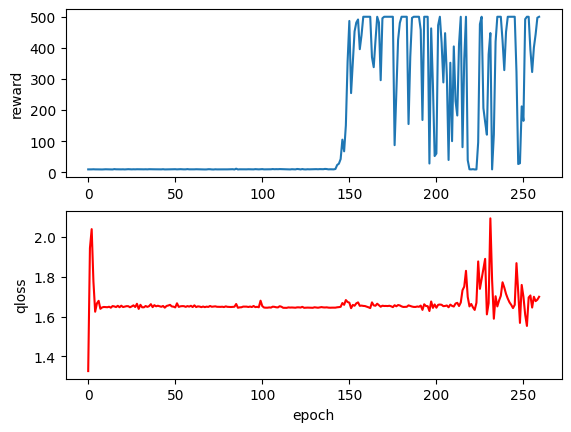

In [469]:
ms += plain_train(net, env, opt, epochs=20)
visualize(ms)

## Stablize the Training

### Experience Replay

As we can see, the `plain_train` is really unstable. We'll first introduce "experience replay", which collects and shuffle losses to make each batch individual. By randomly sampling from the experiences, we break the time dependency and increase individuality.

By training "offline", we collect experience $(s, a, r, s')$. From

$$
r, s' \sim P(s', r | s, a)
$$

we know that the distribution of $r, s'$ is determined only by environment factors,
and is not related to the online policy. In other word, you can act arbitrarily and
still get useful experience; the only difference is the *state region* of the 
experience, e.g. experience near balanced state is hard to collect with a bad-performing policy.

In [528]:
def replay_train(net, env, opt, *, epochs=200, batches=10, tsteps=100):
    experience: list[Experience] = []
    metrics = []
    for _ in range(epochs):
        experience += reduce(add, [trajectory(net, env, 0.01) for _ in range(batches)])
        if len(experience) < tsteps: continue
        exps = sample(experience, k=tsteps)
        opt.zero_grad()
        loss = sum([exp_loss(net, e) for e in exps], torch.tensor(0.)) / tsteps
        loss.backward()
        opt.step()

        tests = reduce(add, [trajectory(net, env, 0.0001) for _ in range(5)])
        tst_loss = sum([exp_loss(net, t) for t in tests], torch.tensor(0.)) / 5
        tst_reward = sum(t[2] for t in tests) / 5
        metrics.append({
            'reward': tst_reward,
            'qloss' : tst_loss.item()
        })

    return metrics


''' Prepare for training '''
net = Qnet()
opt = optim.Adam(net.parameters(), lr=0.001)
ms = [] # a list for results

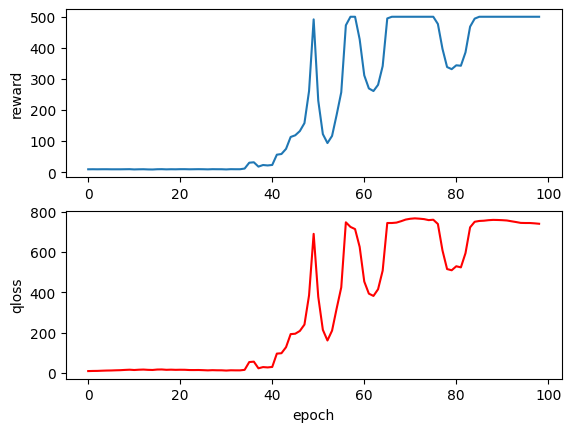

In [530]:
ms += replay_train(net, env, opt, epochs=50)
visualize(ms)

### Seperated Target Net

In [658]:
def replay_train_with_target(env, net, opt, *, epochs=200, batches=10, tsteps=100):
    experience: list[Experience] = []
    tar_net = Qnet()
    tar_net.requires_grad_(False)
    tar_net.load_state_dict(net.state_dict())
    metrics = []

    def counter(period: int):
        val: int = 0
        def count():
            nonlocal val
            val = (val + 1) % period
            return val
        return count
    count = counter(period=5)

    for _ in range(epochs):
        experience += reduce(add, [trajectory(net, env, 0.01) for _ in range(batches)])
        if len(experience) < tsteps: continue
        exps = sample(experience, k=tsteps)
        opt.zero_grad()
        loss = sum([exp_loss(net, e, tnet=tar_net) for e in exps], torch.tensor(0.)) / tsteps
        loss.backward()
        opt.step()
        if count() == 0:
            tar_net.load_state_dict(net.state_dict())

        tests = reduce(add, [trajectory(net, env, 0.0001) for _ in range(5)])
        tst_loss = sum([exp_loss(net, t) for t in tests], torch.tensor(0.)) / 5
        tst_reward = sum(t[2] for t in tests) / 5
        metrics.append({
            'reward': tst_reward,
            'qloss' : tst_loss.item()
        })

    return metrics


''' Prepare for training '''
net = Qnet()
opt = optim.Adam(net.parameters(), lr=0.001)

ms = [] # a list for results

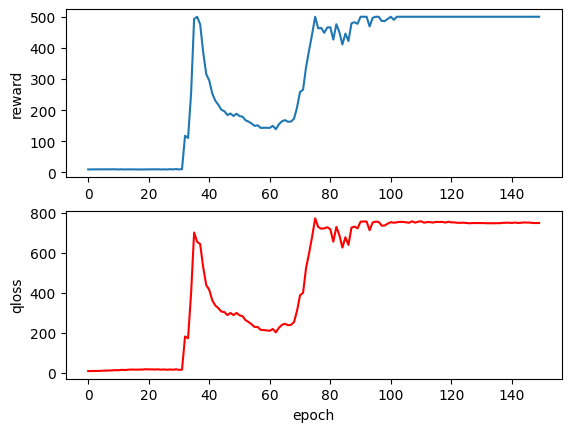

In [661]:
ms += replay_train_with_target(env, net, opt, epochs=50)
visualize(ms)